In [1]:
import pickle
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import regularizers, layers
from sklearn.model_selection import train_test_split

2023-10-07 17:00:00.420552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 17:00:00.420618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 17:00:00.420642: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 17:00:00.428297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 17:00:01.455699: W tensorflow/compiler/

In [2]:
devices = tf.config.list_physical_devices()
tf.config.experimental.set_memory_growth(devices[1], True)
tf.keras.mixed_precision.set_global_policy('float32')
add_on = '_srs'

2023-10-07 17:00:03.678310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 17:00:03.781759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 17:00:03.781825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def save_data(data: object, filename: str) -> None:
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data(filename: str) -> object:
    with open(filename, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

def reformat_to_fp32(data, split=0.5):
    data = data.dropna(axis=0)
    y = data[['Label', 'Binary_Label']]
    X = data.drop(['Label', 'Binary_Label'], axis=1)
    X, y = shuffle(X, y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split, random_state=26442)
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    return X_train, X_val, y_train, y_val

In [4]:
data = load_data(f'./Dataset/scaled_dataset{add_on}.pkl')
#data_2 = load_data('./Dataset/scaled_dataset_noisy_final.pkl')
X_train, X_val, y_train, y_val = reformat_to_fp32(data, 0.45)
y_train = y_train['Label']
y_val = y_val['Label']
#X_train, X_val_2, y_train, y_val_2 = reformat_to_fp32(data_2, 0.1)
print(X_train.shape)
print(y_train.shape)


(7724, 50)
(7724,)


In [5]:
def drop_corr():    
    corr_matrix = data.corr()
    corrs = corr_matrix['Label']
    #print(sorted(corrs))
    corrs = corrs[abs(corrs) > 0.2]
    keep_cols = corrs.index
    keep_cols = keep_cols.drop('Label')
    X_train = X_train[keep_cols]
    X_val = X_val[keep_cols]
    sns.heatmap(corr_matrix)
    plt.show()

In [6]:
# Initialize your list of columns
columns_cur = X_train.columns.to_list()

# Set the threshold for p-values
p_value_threshold = 0.05  # You can adjust this threshold as needed
using_OLS = False
while using_OLS:
    # Fit the multiple linear regression model
    model = sm.OLS(y_train, X_train[columns_cur]).fit()
    
    # Get the p-values for each variable
    p_values = model.pvalues
    
    # Check if all p-values are below the threshold
    if all(p < p_value_threshold for p in p_values):
        break  # Exit the loop if all p-values are below the threshold
    
    # Find the variable with the highest p-value (the one to remove)
    variable_to_remove = p_values.idxmax()
    
    # Remove the variable with the highest p-value from the list
    columns_cur.remove(variable_to_remove)
    
    # Print a summary of the regression results for this iteration
    print("Removed variable:", variable_to_remove)
    #print("Remaining variables:", columns_cur)
    #print("P-values:")
    #print(p_values)
    #print("\n")
if using_OLS:
    print(p_values)
    print(model.summary())
# After the loop, you'll have the final set of variables in columns_cur


In [7]:
#columns_cur = ['pass_completion', 'pass_completion_percent', 'pass_td', 'rush_attempt','rush_td', 'num_plays', 'pass_first_down', 'penalty_first', 'penalty','penalty_yards', 'lost_fumble', 'interceptions','op_pass_completion_percent', 'op_pass_td', 'op_rush_attempt', 'op_avg_rush_yard', 'op_rush_td', 'op_first_downs', 'op_penalty', 'op_penalty_yards', 'op_lost_fumble', 'op_interceptions','op_turnovers', 'Location']

In [8]:
X_train = X_train[columns_cur]
X_val = X_val[columns_cur]

In [9]:
X_train.columns

Index(['Team', 'Location', 'Opponent', 'Conference', 'pass_completion',
       'pass_attempts', 'pass_completion_percent', 'pass_yards', 'pass_td',
       'rush_attempt', 'rush_yards', 'avg_rush_yard', 'rush_td', 'num_plays',
       'total_yard', 'yard_per_play', 'pass_first_down', 'rush_first_down',
       'penalty_first', 'first_downs', 'penalty', 'penalty_yards',
       'lost_fumble', 'interceptions', 'turnovers', 'SRS', 'SOS',
       'op_pass_completion', 'op_pass_attempts', 'op_pass_completion_percent',
       'op_pass_yards', 'op_pass_td', 'op_rush_attempt', 'op_rush_yards',
       'op_avg_rush_yard', 'op_rush_td', 'op_num_plays', 'op_total_yard',
       'op_yard_per_play', 'op_pass_first_down', 'op_rush_first_down',
       'op_penalty_first', 'op_first_downs', 'op_penalty', 'op_penalty_yards',
       'op_lost_fumble', 'op_interceptions', 'op_turnovers', 'op_SRS',
       'op_SOS'],
      dtype='object')

In [10]:
def rmse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.sqrt(mse)

n_features = len(X_train.columns)
width_scale = 4

parameters = {
    'num_epochs': 100,
    'batch_size': 128,
    'learning_rate': 1e-5,
    'loss_fn': tf.keras.losses.log_cosh,
    'drop_pct': 0.125,
    'starting_params': width_scale**5,
    'act_func': 'relu',
    'num_layers': 6,
    'Denominator': 2,
    'hidden_params': width_scale**6,
    'metrics_eval': ['MAE', rmse]
}

In [11]:
def find_rows_with_na_or_non_numeric(df):
    # Find rows with NaN values
    na_rows = df[df.isna().any(axis=1)]
    # Find rows with non-numeric values
    non_numeric_rows = df[~df.applymap(lambda x: isinstance(x, (int, float))).all(axis=1)]
    # Concatenate the two DataFrames to get rows with either NaN or non-numeric values
    rows_with_issues = pd.concat([na_rows, non_numeric_rows]).drop_duplicates()
    return rows_with_issues

def add_dropout_block(model: tf.keras.Sequential, params: int, a_fn: str):
    k_regularizer = regularizers.l1_l2(l1=1e-3, l2=1e-3)
    model.add(tf.keras.layers.Dense(params, activation=a_fn, kernel_regularizer=k_regularizer))
    model.add(tf.keras.layers.Dropout(parameters['drop_pct'])) 
    return model

def make_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(parameters['starting_params'], activation=parameters['act_func'], 
                        kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3), 
                        input_shape=[n_features]))

    model.add(tf.keras.layers.Dropout(parameters['drop_pct'])) 

    parameter_count = parameters['hidden_params'] 
    for _ in range(parameters['num_layers']):
        model = add_dropout_block(model, parameter_count, parameters['act_func'])
        parameter_count /= parameters['Denominator'] 

    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=parameters['learning_rate'])#, clipvalue=1.0) 

    model.compile(loss=parameters['loss_fn'], optimizer=optimizer, metrics=parameters['metrics_eval']) 
    #model.summary()
    return model

def plot_metrics(history, metrics, figsize=(12, 12)):
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=figsize, sharex=True)

    # Convert axes to a 1D array if there's only one metric
    if num_metrics == 1:
        axes = axes.reshape(1, -1)

    for i, metric in enumerate(metrics):
        values = history[metric][2:]
        val_values = history['val_' + metric][2:]

        ax = axes[i]
        ax.plot(range(1, len(values) + 1), values, label=f'Training {metric}')
        ax.plot(range(1, len(val_values) + 1), val_values, label=f'Validation {metric}')
        ax.set_ylabel(metric.capitalize())  # Set metric name as ylabel
        ax.set_title(f'Training and Validation {metric.capitalize()}')
        ax.legend()

    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

def plot_arr(numbers):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(numbers)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Plot of List of Numbers')
    plt.grid(True)
    plt.show()

2023-10-07 17:00:04.003353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 17:00:04.003567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 17:00:04.003646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 17:00:06.116927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-07 17:00:06.117250: I tensorflow/compile

198/198 [==============================] - 2s 9ms/step - loss: 19.5408 - MAE: 8.1907 - rmse: 10.2131


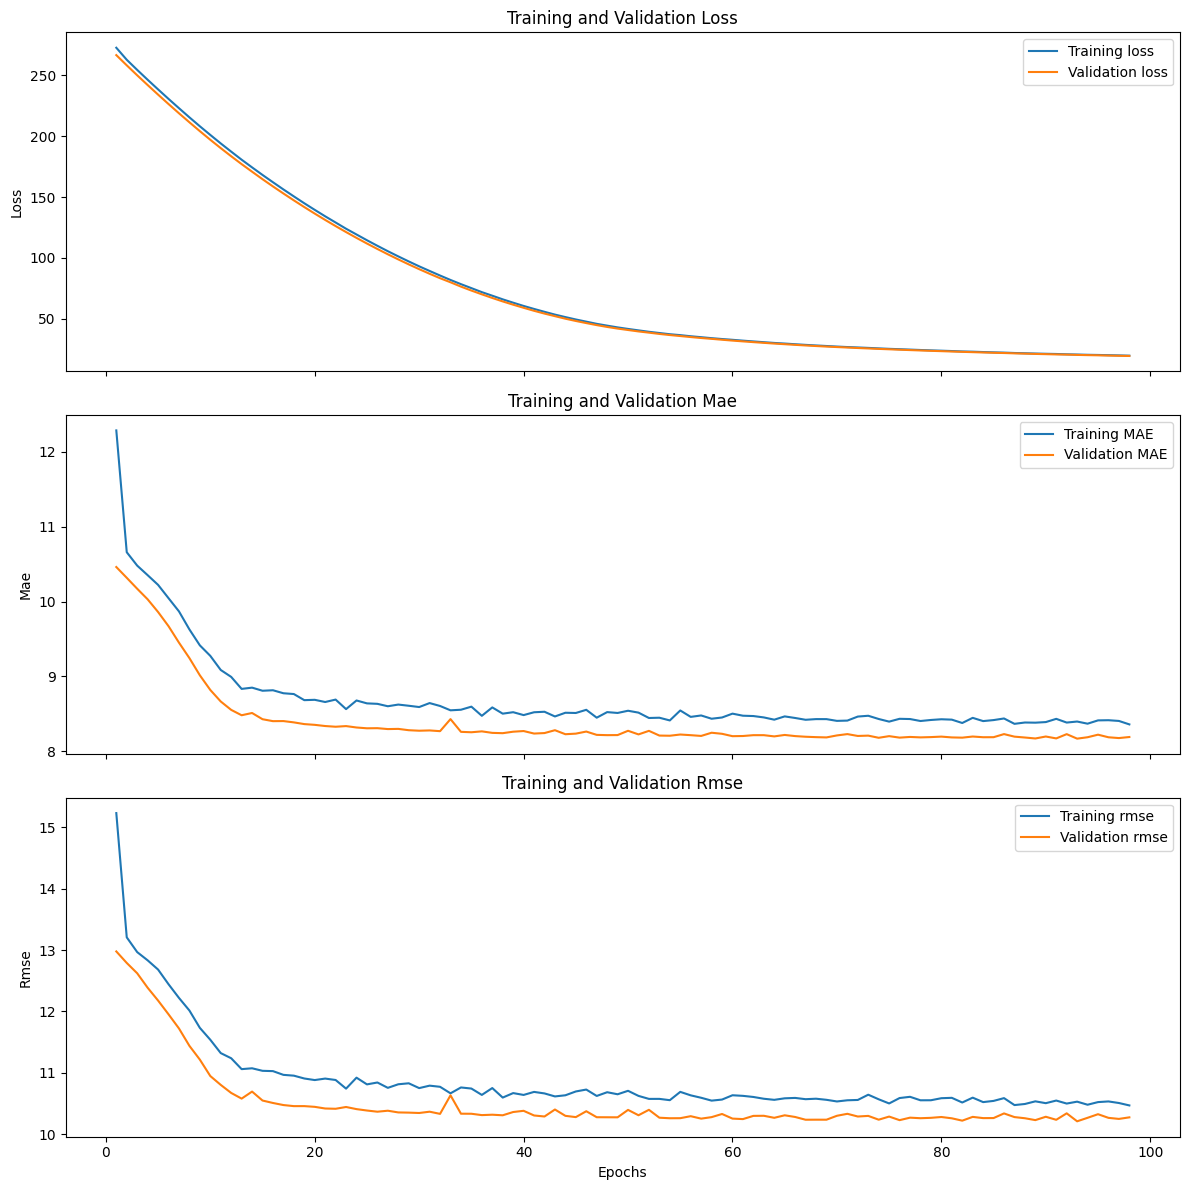

In [12]:
def create_and_plot_model():
    model = make_model()
    history = model.fit(X_train, y_train, epochs=parameters['num_epochs'], batch_size=parameters['batch_size'], validation_data=(X_val, y_val), verbose=0)
    model.evaluate(X_val, y_val)
    # Assuming you have 'history' containing the metrics as mentioned
    metrics_to_plot = ['loss', 'MAE', 'rmse']  # Add the metrics you want to plot here
    # Call the function to plot the metrics
    plot_metrics(history.history, metrics_to_plot)
    return model
trained_model = create_and_plot_model()

In [15]:
def make_predictions(model):
    data = load_data('./Data/predictions/2023-10-07.pkl')
    #print(data)
    minmax = load_data('./Dataset/MMScaler_srs.pkl')
    team_names = data[['Team_name', 'Op_name']]
    team_names.columns = ['Team_name', 'Op_name']
    data = data.drop(['Label', 'Binary_Label', 'Date','Team_name', 'Op_name'], axis=1)
    scaled_data = pd.DataFrame(minmax.transform(data))
    scaled_data.columns = data.columns
    inputs = scaled_data[columns_cur]
    predictions = model.predict(np.array(inputs, dtype=float))
   
    return team_names, predictions

teams_pred, prediction  = make_predictions(trained_model)
teams_pred = teams_pred.reset_index(drop=True)
print(len([index for index, _ in teams_pred.iterrows()]))
#print(teams_pred)
all_names = teams_pred['Team_name'].to_list()
count = 1
rows = []
while len(all_names) > 0:
    name = all_names[0]
    idx = teams_pred[teams_pred['Team_name'] == name].index[0]
    opp = str(teams_pred['Op_name'][idx])
    opp_idx = teams_pred[teams_pred['Team_name'] == opp].index[0]
    name_pred = prediction[idx][0]
    opp_pred = prediction[opp_idx][0]
    #print(f'\t\t{count}: {name} VS. {opp}:')
    #print(f'{name}:{round(name_pred, 2)} Points | {opp}: {round(opp_pred, 2)} Points\n')
    rows.append([name, opp, name_pred, opp_pred])
    all_names.remove(name)
    all_names.remove(opp)
    count += 1

new_preds_df = pd.DataFrame(rows)
new_preds_df.to_csv('./Data/predictions/10-07-23_regs.csv', index=False)

3/3 [==============================] - 0s 15ms/step
94


In [16]:
preds = trained_model.predict(X_val)
print(preds)

198/198 [==============================] - 1s 5ms/step
[[39.782383]
 [16.40385 ]
 [28.063398]
 ...
 [32.52226 ]
 [34.32836 ]
 [25.721144]]


In [ ]:
def test_minibatch():

  evals = []

  batch_size = parameters['batch_size']  
  num_epochs = parameters['num_epochs']

  # Create an instance of your model
  with tf.device('/GPU:0'):
    model = make_model()

  # Get the total number of training samples
  num_samples = len(X_train)

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for i in range(0, num_samples, batch_size):
      
      with tf.device('/GPU:0'):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
      
      # Train the model on the current minibatch  
      with tf.device('/GPU:0'):
        model.train_on_batch(X_batch, y_batch)
        
      # Clear the GPU memory
      tf.keras.backend.clear_session()
      
      # Evaluate the model on the validation data
      with tf.device('/GPU:0'):  
        eval_metrics = model.evaluate(X_val, y_val)
        
      evals.append(eval_metrics[1])

  return evals

metrics_loss = test_minibatch()
plot_arr(metrics_loss)

In [ ]:
def test_run():
    model = make_model()

    history = model.fit(X_train, y_train,
                        epochs=parameters['num_epochs'],
                        batch_size=parameters['batch_size'],
                        validation_data=(X_val, y_val),
                        verbose=0)
    result = model.evaluate(X_val, y_val)
    del model
    tf.keras.backend.clear_session()
    return result

In [ ]:
def itterate_var():
    losses = []
    for scaler in range(2, 5):
        #parameters['drop_pct'] = scaler/10  # - good values 0.2-0.5
        #parameters['learning_rate'] = 10**-scaler
        #parameters['num_epochs'] = scaler
        parameters['start_size'] = 4**(scaler+2)
        parameters['num_layers'] = scaler
        losses.append(test_run()[1])

    plot_arr(losses)
    
itterate_var()